In [ ]:
!git clone https://github.com/YvanYin/Metric3D.git
%cd /content/Metric3D

!pip install torch==2.0.1 torchvision==0.15.2 opencv-python numpy==1.23.1 xformers==0.0.21 Pillow DateTime matplotlib plyfile HTML4Vision timm tensorboardX imgaug iopath imagecorruptions
!pip install openmim
!mim install mmcv

from IPython.display import clear_output
clear_output()

In [ ]:
import requests
import cv2
import torch
import numpy as np

from torchvision import transforms
from tqdm import tqdm
import glob, time

model = torch.hub.load('yvanyin/metric3d', 'metric3d_vit_giant2', pretrain=True)
model.cuda().eval()

from IPython.display import clear_output
clear_output()

In [ ]:
# helper functions
import os

MAX_RANGE = None

outdoor_folder_path = '/content/drive/MyDrive/PW/Praca/DIODE_evaluation/outdoor/*/*/*.png'
indoor_folder_path = '/content/drive/MyDrive/PW/Praca/DIODE_evaluation/indoors/*/*/*.png'
nyu_folder_path = '/content/drive/MyDrive/PW/Praca/NYUv2/rgb/*.jpg'
stray_folder_path = '/content/drive/MyDrive/PW/Praca/stray_dataset/*/first_frame.png'
stray_indoor_folder_path = '/content/drive/MyDrive/PW/Praca/stray_indoor/*/first_frame.png'
kitti_folder_path = '/content/drive/MyDrive/PW/Praca/kitti_evaluation/image/*.png'
vkitti2_folder_path = '/content/drive/MyDrive/PW/Praca/vkitti2_evaluation/vkitti_2.0.3_rgb/*/15-deg-left/frames/rgb/Camera_0/*.jpg'
taskonomy_folder_path = '/content/drive/MyDrive/PW/Praca/Taskonomy/rgb/allensville/*.png'
actual_path = stray_indoor_folder_path

def get_gt_path(image_path):
    if actual_path in [indoor_folder_path, outdoor_folder_path]:
        gt_path = image_path.replace('.png', '_depth.npy')
    elif actual_path in [stray_folder_path, stray_indoor_folder_path]:
        gt_path = image_path.replace('first_frame.png', 'depth/000000.png')
    elif actual_path == nyu_folder_path:
        dir_name, image_name = os.path.split(image_path)
        gt_path = os.path.join(dir_name.replace('rgb', 'depth'), image_name.replace('jpg', 'npy'))
    elif actual_path == vkitti2_folder_path:
        gt_path = image_path.replace('rgb', 'depth').replace('jpg', 'png')
    elif actual_path == kitti_folder_path:
        gt_path = image_path.replace('image', 'groundtruth_depth', 2)
    elif actual_path == taskonomy_folder_path:
        gt_path = image_path.replace('rgb', 'depth_euclidean')
    return gt_path

def get_error_mask(gt):
    if actual_path in [indoor_folder_path, outdoor_folder_path]:
        if MAX_RANGE:
            mask = (gt > 0.6) & (gt < MAX_RANGE)
        else:
            mask = (gt > 0.6) & (gt < 350)
    elif actual_path in [stray_folder_path, stray_indoor_folder_path]:
        mask = (gt > 0.3) & (gt < 5)
    elif actual_path == nyu_folder_path:
        mask = (gt > 0) & (gt < 10)
    elif actual_path == vkitti2_folder_path:
        if MAX_RANGE:
            mask = (gt > 2.5) & (gt < MAX_RANGE)
        else:
            mask = (gt > 2.5) & (gt < 85)
    elif actual_path == kitti_folder_path:
        if MAX_RANGE:
            mask = (gt > 0) & (gt < MAX_RANGE)
        else:
            mask = (gt > 0)
    elif actual_path == taskonomy_folder_path:
        if MAX_RANGE:
            mask = (gt > 0) & (gt < MAX_RANGE)
        else:
            mask = (gt > 0) & (gt < 128)
    return mask

def get_depth_gt(gt_path):
    if actual_path in [outdoor_folder_path, indoor_folder_path]:
        depth_gt = np.load(gt_path).squeeze()
    elif actual_path == nyu_folder_path:
        depth_gt = np.load(gt_path)
    elif actual_path in [stray_folder_path, stray_indoor_folder_path]:
        depth_gt = cv2.imread(gt_path, -1) / 1000
    elif actual_path == vkitti2_folder_path:
        depth_gt = cv2.imread(gt_path, cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH) / 100
    elif actual_path == kitti_folder_path:
        depth_gt = cv2.imread(gt_path, 0)
    elif actual_path == taskonomy_folder_path:
        depth_gt = cv2.imread(gt_path, -1) / 512
    return depth_gt

def compute_errors(gt, pred):
    mask = get_error_mask(gt)
    gt = gt[mask]
    pred = pred[mask]

    thresh = np.maximum((gt / pred), (pred / gt))
    a1 = (thresh < 1.25).mean()
    a2 = (thresh < 1.25 ** 2).mean()
    a3 = (thresh < 1.25 ** 3).mean()

    abs_rel = np.mean((np.abs(gt - pred) / gt))
    sq_rel = np.mean((((gt - pred) ** 2) / gt))

    rmse = (gt - pred) ** 2
    rmse = np.sqrt(rmse.mean())

    rmse_log = (np.log(gt) - np.log(pred)) ** 2
    rmse_log = np.sqrt(rmse_log.mean())

    err = (np.log(pred) - np.log(gt))
    silog = np.sqrt(np.mean(err ** 2) - np.mean(err) ** 2) * 100

    log_10 = (np.abs(np.log10(gt) - np.log10(pred))).mean()
    return dict(a1=a1, a2=a2, a3=a3, abs_rel=abs_rel, rmse=rmse, log_10=log_10, rmse_log=rmse_log,
                silog=silog, sq_rel=sq_rel)

def get_intrinsic(rgb_origin):
    if actual_path in [outdoor_folder_path, indoor_folder_path]:
        intrinsic = [886.81, 927.06, 512, 384]
    elif actual_path == nyu_folder_path:
        intrinsic = [542.0, 542.0, 963.706, 760.199]
    elif actual_path in [stray_folder_path, stray_indoor_folder_path]:
        intrinsic = [1330.0, 1330.0, rgb_origin.shape[1]/2, rgb_origin.shape[0]/2]
    elif actual_path == vkitti2_folder_path:
        intrinsic = [725.0087, 725.0087, rgb_origin.shape[1]/2, rgb_origin.shape[0]/2]
    elif actual_path == kitti_folder_path:
        intrinsic = [721.5377, 609.5593, rgb_origin.shape[1]/2, rgb_origin.shape[0]/2]
    elif actual_path == taskonomy_folder_path:
        intrinsic = [435.33, 435.33, rgb_origin.shape[1]/2, rgb_origin.shape[0]/2]
    return intrinsic

In [ ]:
import time, glob
from tqdm import tqdm

results = []
images = [i for i in glob.iglob(actual_path, recursive=True)]
for image_path in tqdm(images):
    gt_path = get_gt_path(image_path)
    start_time = time.time()

    rgb_origin = cv2.imread(image_path)[:, :, ::-1]
    input_size = (616, 1064) # for vit model
    h, w = rgb_origin.shape[:2]
    scale = min(input_size[0] / h, input_size[1] / w)
    new_size = (int(w * scale), int(h * scale))
    rgb = cv2.resize(rgb_origin, new_size, interpolation=cv2.INTER_LINEAR)

    # INTRINSIC!!!
    intrinsic = get_intrinsic(rgb_origin)
    intrinsic = [intrinsic[0] * scale, intrinsic[1] * scale, intrinsic[2] * scale, intrinsic[3] * scale]
    # ///

    padding = [123.675, 116.28, 103.53]
    h, w = rgb.shape[:2]
    pad_h = input_size[0] - h
    pad_w = input_size[1] - w
    pad_h_half = pad_h // 2
    pad_w_half = pad_w // 2
    rgb = cv2.copyMakeBorder(rgb, pad_h_half, pad_h - pad_h_half, pad_w_half, pad_w - pad_w_half, cv2.BORDER_CONSTANT, value=padding)
    pad_info = [pad_h_half, pad_h - pad_h_half, pad_w_half, pad_w - pad_w_half]
    mean = torch.tensor([123.675, 116.28, 103.53]).float()[:, None, None]
    std = torch.tensor([58.395, 57.12, 57.375]).float()[:, None, None]
    rgb = torch.from_numpy(rgb.transpose((2, 0, 1))).float()
    rgb = torch.div((rgb - mean), std)
    rgb = rgb[None, :, :, :].cuda()

    with torch.no_grad():
        pred_depth, confidence, output_dict = model.inference({'input': rgb})
    pred_depth = pred_depth.squeeze()
    pad_info = [pad_h_half, pad_h - pad_h_half, pad_w_half, pad_w - pad_w_half]
    pred_depth = pred_depth[pad_info[0] : pred_depth.shape[0] - pad_info[1], pad_info[2] : pred_depth.shape[1] - pad_info[3]]
    pred_depth = torch.nn.functional.interpolate(pred_depth[None, None, :, :], rgb_origin.shape[:2], mode='bilinear').squeeze()

    # INTRINSIC 2!!!
    canonical_to_real_scale = intrinsic[0] / 1000.0 # 1000.0 is the focal length of canonical camera
    pred_depth = pred_depth * canonical_to_real_scale # now the depth is metric
    # ///

    pred_depth = pred_depth.cpu().numpy()

    if actual_path in [stray_folder_path, stray_indoor_folder_path]:
        pred_depth = cv2.resize(pred_depth, (256, 192))

    exec_time = (time.time() - start_time)
    results.append({'pred_depth': pred_depth, 'gt_path': gt_path, 'exec_time': exec_time})

100%|██████████| 10/10 [00:23<00:00,  2.32s/it]


In [ ]:
import numpy as np
import cv2

# compute errors on results
metrics = []
print("computing errors...")
for result in tqdm(results):
    depth_gt = get_depth_gt(result['gt_path'])
    metrics.append({"exec_time": result['exec_time'], **compute_errors(depth_gt, result['pred_depth'])})

# compute mean values
values_list = {
    "a1": [],
    "a2": [],
    "a3": [],
    "abs_rel": [],
    "rmse": [],
    "log_10": [],
    "rmse_log": [],
    "silog": [],
    "sq_rel": [],
    "exec_time": [],
}
for metric in metrics:
    for key, value in metric.items():
        values_list[key].append(value)

mean_values = {}
for key, value in values_list.items():
    mean_values[key] = sum(value) / len(value)

print('\n', mean_values)

computing errors...


100%|██████████| 10/10 [00:14<00:00,  1.40s/it]


 {'a1': 0.9966746054805731, 'a2': 0.9998023720232998, 'a3': 0.9999805823984733, 'abs_rel': 0.05958721712231636, 'rmse': 1.473571515083313, 'log_10': 0.024958794005215168, 'rmse_log': 0.07122740633785725, 'silog': 5.444424647006595, 'sq_rel': 0.07821164242923259, 'exec_time': 4.242156434059143}


2.8610198
2.4842012
/content/drive/MyDrive/PW/Praca/DIODE_evaluation/indoors/scene_00021/scan_00189/00021_00189_indoors_130_000_depth.npy


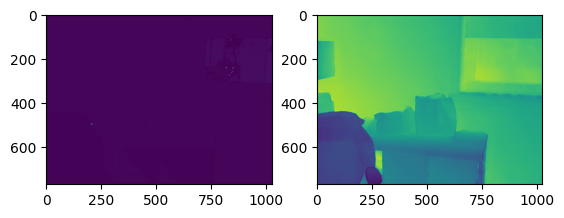

In [ ]:
# debug set

num = 0
y, x = (150, 10)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

print(gt_depth[y][x])
print(pred_depth[y][x])
print(results[num]['gt_path'])

import matplotlib.pyplot as plt
f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(gt_depth)
f.add_subplot(1,2, 2)
plt.imshow(pred_depth)
plt.show(block=True)

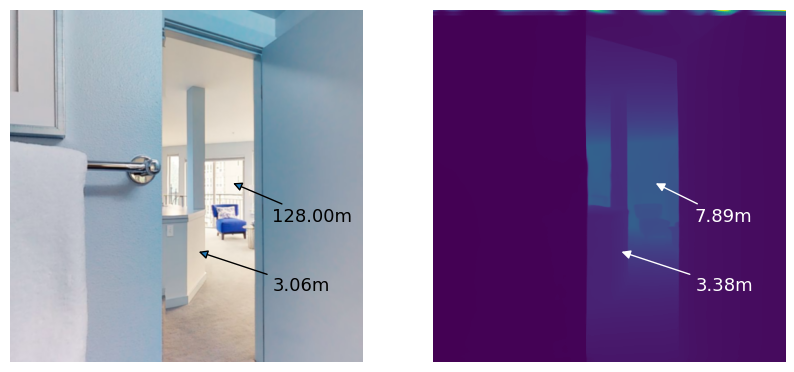

In [ ]:
# Taskonomy visualisation

num = 9
y, x = (250, 320)
y2, x2 = (350, 270)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('depth_euclidean', 'rgb')

fontsize = 13
xytext1 = (30, -25)
xytext2 = (55, -25)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.imread(rgb_path))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)

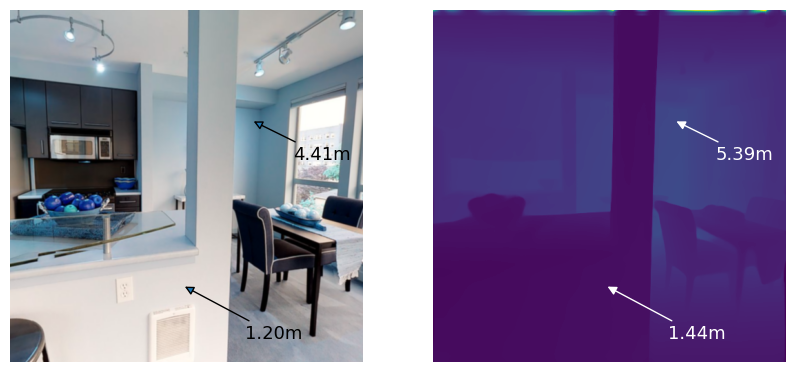

In [ ]:
# Taskonomy visualisation

num = 3
y, x = (160, 350)
y2, x2 = (400, 250)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('depth_euclidean', 'rgb')

fontsize = 13
xytext1 = (30, -25)
xytext2 = (45, -35)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.imread(rgb_path))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)

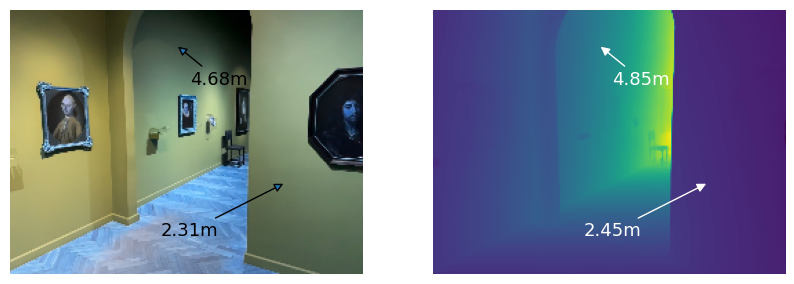

In [ ]:
# Stray indoor visualisation

num = 7
y, x = (25, 120)
y2, x2 = (125, 200)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('depth/000000.png', 'first_frame.png')

fontsize = 13
xytext1 = (10, -25)
xytext2 = (-90, -35)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.resize(cv2.imread(rgb_path), (256, 192)))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)

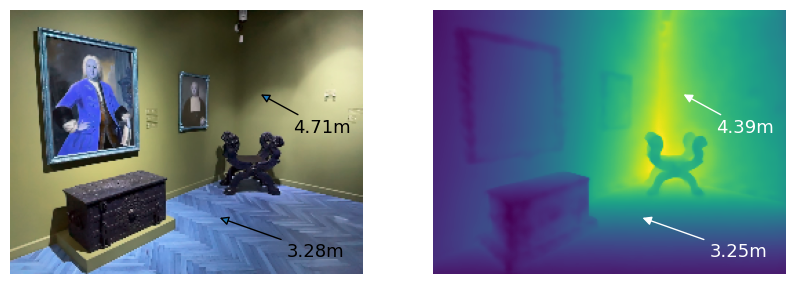

In [ ]:
# Stray indoor visualisation

num = 9
y, x = (60, 180)
y2, x2 = (150, 150)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('depth/000000.png', 'first_frame.png')

fontsize = 13
xytext1 = (25, -25)
xytext2 = (50, -25)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.resize(cv2.imread(rgb_path), (256, 192)))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)

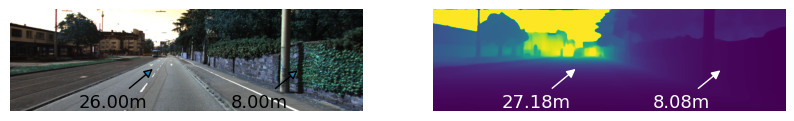

In [ ]:
# KITTI visualisation

num = 4
y, x = (205, 1000)
y2, x2 = (200, 500)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('groundtruth_depth', 'image', 2)

fontsize = 13
xytext1 = (-50, -24)
xytext2 = (-55, -25)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.imread(rgb_path))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)

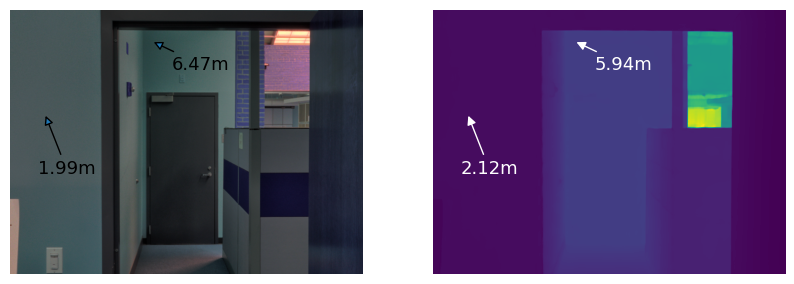

In [ ]:
# DIODE indoor visualisation

num = 1
y, x = (300, 100)
y2, x2 = (90, 410)

gt_depth = get_depth_gt(results[num]['gt_path'])
pred_depth = results[num]['pred_depth']

rgb_path = results[num]['gt_path'].replace('_depth.npy', '.png')

fontsize = 13
xytext1 = (-5, -40)
xytext2 = (15, -17)

import matplotlib.pyplot as plt
f = plt.figure(figsize=(10, 15))
ax = f.add_subplot(1, 2, 1)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(gt_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')
ax.annotate("{:.2f}m".format(gt_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>'}, fontsize=fontsize, va='center')

plt.imshow(cv2.imread(rgb_path))
ax = f.add_subplot(1, 2, 2)
ax.set_axis_off()
ax.annotate("{:.2f}m".format(pred_depth[y][x]), (x, y), xytext=xytext1, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')
ax.annotate("{:.2f}m".format(pred_depth[y2][x2]), (x2, y2), xytext=xytext2, textcoords='offset points', arrowprops={'arrowstyle': '-|>', 'color': 'white'}, fontsize=fontsize, color='white', va='center')

plt.imshow(pred_depth)
plt.show(block=True)